# Local-Tangent DDM + Geometric Harmonics

We compare a plain time-domain linear interpolation against the **local geometric harmonics (LGH)** pipeline:

1. Build the separable+coupling operator $P=(1-\eta)P_{	ext{geo}}+\eta P_{	ext{cpl}}$ to encode diffusion (geometry) and deterministic forward transport.
2. Embed frames with diffusion maps (symmetric part of $P$), fit monotone transport splines in the latent chart, and evaluate them at the held-out time.
3. Apply **local** GH lifting (k-NN Nyström + ridge) to reconstruct the held-out frames and compare against the linear baseline.

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys


def format_for_paper() -> None:
    """Apply publication-style defaults for matplotlib figures."""
    plt.rcParams.update({"image.cmap": "viridis"})
    plt.rcParams.update(
        {
            "font.serif": [
                "Times New Roman",
                "Times",
                "DejaVu Serif",
                "Bitstream Vera Serif",
                "Computer Modern Roman",
                "New Century Schoolbook",
                "Century Schoolbook L",
                "Utopia",
                "ITC Bookman",
                "Bookman",
                "Nimbus Roman No9 L",
                "Palatino",
                "Charter",
                "serif",
            ]
        }
    )
    plt.rcParams.update({"font.family": "serif"})
    plt.rcParams.update({"font.size": 10})
    plt.rcParams.update({"mathtext.fontset": "custom"})
    plt.rcParams.update({"mathtext.rm": "serif"})
    plt.rcParams.update({"mathtext.it": "serif:italic"})
    plt.rcParams.update({"mathtext.bf": "serif:bold"})
    plt.close("all")


format_for_paper()

sys.path.append(str(Path.cwd().parent))

PROJECT_ROOT = Path.cwd().resolve()
DATA_PATH = None
for candidate in (PROJECT_ROOT / 'data/mm_data_large_whiten.npz', PROJECT_ROOT.parent / 'data/mm_data_large_whiten.npz'):
    if candidate.exists():
        DATA_PATH = candidate
        break
if DATA_PATH is None:
    raise FileNotFoundError('Could not locate data/mm_data_large_whiten.npz relative to this notebook.')

print(f"Using dataset: {DATA_PATH}")


def load_full_dataset_pca() -> tuple[
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    int,
    np.ndarray,
    bool,
]:
    """Load global PCA coefficients and return both globally whitened and unscaled views."""
    data = np.load(DATA_PATH)
    keys = sorted(
        [k for k in data.files if k.startswith('marginal_') and not k.startswith('raw_')],
        key=lambda k: float(k.split('_')[-1]),
    )
    times = np.array([float(k.split('_')[-1]) for k in keys], dtype=np.float64)

    coeffs = [data[k] for k in keys]
    components = data['pca_components']
    mean = data['pca_mean']
    variance = data['pca_explained_variance']
    whitened = bool(data['is_whitened'])
    side = int(np.sqrt(int(data['data_dim'])))
    sqrt_var = np.sqrt(np.maximum(variance, 1e-12))

    frames_raw = np.stack(coeffs)  # (n_times, n_samples, components)
    if whitened:
        frames_global = frames_raw
        frames_unscaled = frames_raw * sqrt_var[np.newaxis, np.newaxis, :]
    else:
        frames_unscaled = frames_raw
        frames_global = frames_raw / sqrt_var[np.newaxis, np.newaxis, :]

    return (
        times,
        frames_global,
        frames_unscaled,
        mean,
        components,
        side,
        sqrt_var,
        whitened,
    )


(
    all_times,
    all_frames_global,
    all_frames_unscaled,
    mean,
    components,
    side,
    sqrt_var,
    dataset_whitened,
) = load_full_dataset_pca()
all_frames = all_frames_global  # alias used throughout for physical PCA coordinates
n_times, n_samples, n_components = all_frames.shape
print(
    f"Recovered dataset shape: {all_frames.shape} (time, samples, components); "
    f"is_whitened_on_disk={dataset_whitened}"
)
print(f"Time grid: {all_times}")

Using dataset: /data1/jy384/research/MMSFM/data/mm_data_large_whiten.npz
Recovered dataset shape: (5, 5000, 593) (time, samples, components); is_whitened_on_disk=True
Time grid: [0.   0.25 0.5  0.75 1.  ]


In [2]:
all_frames.shape

(5, 5000, 593)

### Metric space without per-time whitening
We keep the global PCA coordinates for both the physical and metric views. This avoids time-dependent rescaling so the diffusion kernels operate in the same all-frames scale throughout time.

In [3]:
import pandas as pd
from IPython.display import display

# Use the global PCA coordinates directly as the diffusion metric (no per-time whitening).
metric_all_frames = all_frames
print('Metric frames use the global PCA coordinates (no per-time whitening).')

# Track variance across time to monitor scale drift in the physical PCA space.
per_time_variance = metric_all_frames.var(axis=1, ddof=1)
variance_summary = pd.DataFrame(
    {
        'time': all_times,
        'median_variance': np.median(per_time_variance, axis=1),
        'min_variance': np.min(per_time_variance, axis=1),
        'max_variance': np.max(per_time_variance, axis=1),
    }
)
display(variance_summary.head())


Metric frames use the global PCA coordinates (no per-time whitening).


,time,median_variance,min_variance,max_variance
0,0.00,4.983718,1.040178,4.991802
1,0.25,0.012827,0.007150,1.549196
2,0.50,0.002391,0.000789,1.123153
3,0.75,0.000483,0.000095,0.980388
4,1.00,0.000102,0.000007,0.948707


In [4]:
# check mean and covariance
recovered_mean = np.mean(all_frames.reshape(-1, n_components), axis=0)
recovered_cov = np.cov(all_frames.reshape(-1, n_components), rowvar=False)
print(f"Recovered mean (first 5 components): {recovered_mean[:5]}")
print(f"Recovered covariance diagonal (first 5 components): {np.diag(recovered_cov)[:5]}")

Recovered mean (first 5 components): [-9.8393559e-07  1.2653616e-06 -8.0919057e-07 -1.6682959e-06
  3.6309956e-08]
Recovered covariance diagonal (first 5 components): [1.00000008 1.00000086 1.00000088 0.99999974 0.99999965]


In [5]:
holdout_idx = len(all_times) // 2
train_times = np.delete(all_times, holdout_idx)
holdout_time = float(all_times[holdout_idx])
holdout_frames = all_frames[holdout_idx]
holdout_frames_metric = metric_all_frames[holdout_idx]

train_frames = np.delete(all_frames, holdout_idx, axis=0)
metric_train_frames = np.delete(metric_all_frames, holdout_idx, axis=0)
T_train = train_frames.shape[0]

# Flatten training frames into sample-major order (samples × times).
tabular_train_frames = train_frames.transpose(1, 0, 2).reshape(-1, n_components)

print(f"Held-out time: t = {holdout_time:.2f}; training slices: {train_times}")
print(
    f"Total training tuples: {tabular_train_frames.shape[0]} = {n_samples} samples × {T_train} times"
)
print('Metric frames share the global PCA scale (no per-time whitening).')

# Simple linear baseline evaluated sample-wise
lower_mask = train_times < holdout_time
upper_mask = train_times > holdout_time
linear_rmse = None
linear_pred = None
linear_rmse_per_sample = None
if np.any(lower_mask) and np.any(upper_mask):
    t_lo = train_times[lower_mask][-1]
    t_hi = train_times[upper_mask][0]
    time_to_idx = {t: idx for idx, t in enumerate(train_times)}
    frame_lo = train_frames[time_to_idx[t_lo]]
    frame_hi = train_frames[time_to_idx[t_hi]]
    w = (holdout_time - t_lo) / (t_hi - t_lo)
    linear_pred = (1 - w) * frame_lo + w * frame_hi
    linear_rmse_per_sample = np.sqrt(np.mean((linear_pred - holdout_frames) ** 2, axis=1))
    linear_rmse = float(linear_rmse_per_sample.mean())
    print(f"Linear baseline mean RMSE: {linear_rmse:.4f}")
else:
    print('Linear baseline unavailable (held-out slice at boundary).')


Held-out time: t = 0.50; training slices: [0.   0.25 0.75 1.  ]
Total training tuples: 20000 = 5000 samples × 4 times
Metric frames share the global PCA scale (no per-time whitening).
Linear baseline mean RMSE: 0.0699


In [6]:
from diffmap.diffusion_maps import (
    time_coupled_diffusion_map,
    build_time_coupled_trajectory,
    fit_coordinate_splines,
    evaluate_coordinate_splines,
    fit_geometric_harmonics,
    geometric_harmonics_lift,
    geometric_harmonics_lift_local,
)

tc_k = 8
tc_alpha = 0.5
tc_beta = -0.2
use_variable_bandwidth = True


In [7]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


def compute_bandwidth_statistics(frames: np.ndarray) -> dict[str, np.ndarray]:
    medians = []
    q1 = []
    q3 = []
    maxima = []
    for idx, snapshot in enumerate(frames):
        d2 = squareform(pdist(snapshot, metric='sqeuclidean'))
        mask = d2 > 0
        if np.any(mask):
            vals = d2[mask]
            medians.append(float(np.median(vals)))
            q1.append(float(np.percentile(vals, 25)))
            q3.append(float(np.percentile(vals, 75)))
            maxima.append(float(np.max(vals)))
        else:
            medians.append(1.0)
            q1.append(1.0)
            q3.append(1.0)
            maxima.append(1.0)
    return {
        'median': np.array(medians),
        'q1': np.array(q1),
        'q3': np.array(q3),
        'max': np.array(maxima),
    }


bandwidth_stats_metric = compute_bandwidth_statistics(metric_train_frames)
base_epsilons = bandwidth_stats_metric['median']
print('Per-time heuristic bandwidths on global PCA coordinates (median squared distances):')
for idx, eps in enumerate(base_epsilons):
    print(
        f"  τ={train_times[idx]:.2f}: median={eps:.3e}, IQR=({bandwidth_stats_metric['q1'][idx]:.3e}, {bandwidth_stats_metric['q3'][idx]:.3e})"
    )


Per-time heuristic bandwidths on global PCA coordinates (median squared distances):
  τ=0.00: median=5.738e+03, IQR=(5.527e+03, 5.953e+03)
  τ=0.25: median=1.316e+02, IQR=(1.160e+02, 1.489e+02)
  τ=0.75: median=1.023e+01, IQR=(7.374e+00, 1.392e+01)
  τ=1.00: median=2.543e+00, IQR=(1.486e+00, 4.423e+00)


## Connectivity-based bandwidth selection (decoupled from physical time)
We pick per-time baseline $\epsilon_t$ so that the (variable) kernel has a target number of effective neighbours (weights above $e^{-1}$). This treats $\epsilon$ as an algorithmic step size, independent of the physical time spacing, and avoids over-fitting to the contracting dynamics.


### Why $\epsilon$ still matters with variable bandwidth
The KDE-based bandwidths $\rho_i$ only set **relative** local scales. The baseline $\epsilon$ remains the global step size that controls how much diffusion you apply between neighbours. We tune $\epsilon_t$ by connectivity (target neighbours) rather than physical time spacing so the algorithmic step stays decoupled from the contracting dynamics.


In [8]:
from typing import Optional
from diffmap.diffusion_maps import _row_normalize_kernel, _estimate_kde_density

def _mean_neighbors(kernel: np.ndarray) -> float:
    return float(np.mean((kernel > np.exp(-1)).sum(axis=1) - 1))

def select_epsilons_by_connectivity(
    frames: np.ndarray,
    times: np.ndarray,
    base_epsilons: np.ndarray,
    scales: np.ndarray,
    *,
    alpha: float,
    target_neighbors: float = 75.0,
    sample_size: int | None = 2048,
    rng_seed: int = 0,
    variable_bandwidth: bool = True,
    beta: float = -0.2,
    density_bandwidths: Optional[np.ndarray] = None,
):
    "Choose epsilons that hit a target effective neighbour count."
    rng = np.random.default_rng(rng_seed)
    n_times = frames.shape[0]
    chosen_eps = np.zeros(n_times, dtype=np.float64)
    kde_bandwidths = []
    diagnostics: list[dict[str, float]] = []

    for idx in range(n_times):
        snap = frames[idx]
        if sample_size is not None and snap.shape[0] > sample_size:
            subset = rng.choice(snap.shape[0], size=sample_size, replace=False)
            snap_sub = snap[subset]
        else:
            snap_sub = snap
        d2 = squareform(pdist(snap_sub, metric='sqeuclidean'))
        density_bw = None if density_bandwidths is None else float(density_bandwidths[idx])
        best: Optional[dict[str, float]] = None

        for scale in scales:
            eps = float(max(base_epsilons[idx] * scale, 1e-12))
            if variable_bandwidth:
                density, kde_bw_used = _estimate_kde_density(snap_sub, bandwidth=density_bw)
                rho = np.power(density / np.mean(density), beta)
                rho_sum = np.maximum(rho[:, None] + rho[None, :], 1e-12)
                scale_matrix = 2.0 * eps * rho_sum
                kernel = np.exp(-d2 / scale_matrix)
                kde_bw_effective = float(kde_bw_used)
            else:
                kernel = np.exp(-d2 / (4.0 * eps))
                kde_bw_effective = float('nan')
            np.fill_diagonal(kernel, 0.0)
            try:
                _row_normalize_kernel(kernel, alpha=alpha)
            except ValueError:
                continue
            mean_neighbors = _mean_neighbors(kernel)
            score = abs(mean_neighbors - target_neighbors)
            diagnostics.append(
                {
                    'time_idx': idx,
                    'time': float(times[idx]),
                    'scale': float(scale),
                    'epsilon': eps,
                    'mean_neighbors': mean_neighbors,
                    'score': score,
                    'kde_bandwidth': kde_bw_effective,
                    'subset_size': snap_sub.shape[0],
                }
            )
            if best is None or score < best['score']:
                best = {
                    'epsilon': eps,
                    'score': score,
                    'mean_neighbors': mean_neighbors,
                    'kde_bandwidth': kde_bw_effective,
                }

        if best is None:
            raise RuntimeError(f'No feasible epsilon found for time index {idx}.')
        chosen_eps[idx] = best['epsilon']
        kde_bandwidths.append(best['kde_bandwidth'])

    diagnostics_df = pd.DataFrame(diagnostics)
    return chosen_eps, np.array(kde_bandwidths), diagnostics_df


In [9]:
epsilon_scale_grid = np.geomspace(0.1, 4.0, num=32)
exploration_sample_size = min(1024, n_samples)
target_neighbors = 64
print(
    f'Selecting epsilons by neighbour count on {len(train_times)} time slices with sample_size={exploration_sample_size} '
    f'and {len(epsilon_scale_grid)} scales (variable_bandwidth={use_variable_bandwidth}).'
)

selected_epsilons_arr, base_density_bandwidths, connectivity_grid = select_epsilons_by_connectivity(
    metric_train_frames,
    train_times,
    base_epsilons,
    epsilon_scale_grid,
    alpha=tc_alpha,
    target_neighbors=target_neighbors,
    sample_size=exploration_sample_size,
    rng_seed=0,
    variable_bandwidth=use_variable_bandwidth,
    beta=tc_beta,
)
selected_epsilons = selected_epsilons_arr.tolist()
print('Neighbour-count selection complete:')
print([f'{e:.3e}' for e in selected_epsilons])
print('Base KDE bandwidths (per time):', [f'{bw:.3e}' for bw in base_density_bandwidths])


Selecting epsilons by neighbour count on 4 time slices with sample_size=1024 and 32 scales (variable_bandwidth=True).
Neighbour-count selection complete:
['1.320e+03', '2.386e+01', '1.153e+00', '2.543e-01']
Base KDE bandwidths (per time): ['3.111e+00', '4.713e-01', '1.323e-01', '6.601e-02']


<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_204614/617494197.py:7: SyntaxWarning: invalid escape sequence '\e'
  ax.set(xlabel='time', ylabel='epsilon', title='Connectivity-tuned $\epsilon_t$')
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


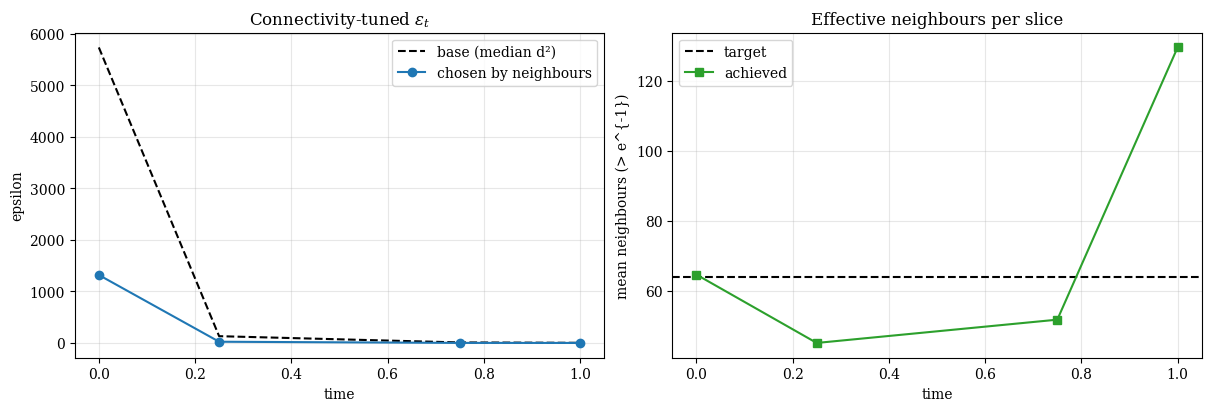

In [10]:
best_by_time = connectivity_grid.sort_values('score').groupby('time_idx').first()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax = axes[0]
ax.plot(train_times, base_epsilons, 'k--', label='base (median d²)')
ax.plot(train_times, selected_epsilons_arr, 'o-', label='chosen by neighbours')
ax.set(xlabel='time', ylabel='epsilon', title='Connectivity-tuned $\epsilon_t$')
ax.grid(alpha=0.3)
ax.legend()

ax = axes[1]
ax.axhline(target_neighbors, color='k', linestyle='--', label='target')
ax.plot(train_times, best_by_time['mean_neighbors'].values, 's-', color='tab:green', label='achieved')
ax.set(xlabel='time', ylabel='mean neighbours (> e^{-1})', title='Effective neighbours per slice')
ax.grid(alpha=0.3)
ax.legend()
plt.show()


In [11]:
from diffmap.diffusion_maps import _time_slice_markov
from sklearn.decomposition import TruncatedSVD

connectivity_check_rows = []
for idx in range(len(selected_epsilons)):
    P_t, eps_used, kde_bw_used = _time_slice_markov(
        metric_train_frames[idx],
        epsilon=selected_epsilons[idx],
        alpha=tc_alpha,
        variable_bandwidth=use_variable_bandwidth,
        beta=tc_beta,
        density_bandwidth=base_density_bandwidths[idx],
    )
    d2_full = squareform(pdist(metric_train_frames[idx], metric='sqeuclidean'))
    if use_variable_bandwidth:
        density, _ = _estimate_kde_density(metric_train_frames[idx], bandwidth=base_density_bandwidths[idx])
        rho = np.power(density / np.mean(density), tc_beta)
        rho_sum = np.maximum(rho[:, None] + rho[None, :], 1e-12)
        scale = 2.0 * eps_used * rho_sum
        kernel_full = np.exp(-d2_full / scale)
    else:
        kernel_full = np.exp(-d2_full / (4.0 * eps_used))
    np.fill_diagonal(kernel_full, 0.0)
    mean_neighbors_full = _mean_neighbors(kernel_full)

    svd_slice = TruncatedSVD(n_components=min(6, P_t.shape[0]-1), algorithm='randomized', random_state=42)
    U_sigma = svd_slice.fit_transform(P_t)
    sigma = svd_slice.singular_values_
    gap = float(sigma[0] - sigma[1]) if len(sigma) > 1 else float('nan')

    connectivity_check_rows.append(
        {
            'time_idx': idx,
            'time': float(train_times[idx]),
            'epsilon': float(eps_used),
            'kde_bandwidth': float(kde_bw_used) if kde_bw_used is not None else float('nan'),
            'mean_neighbors_full': mean_neighbors_full,
            'sigma1': float(sigma[0]) if len(sigma) > 0 else float('nan'),
            'sigma2': float(sigma[1]) if len(sigma) > 1 else float('nan'),
            'spectral_gap': gap,
        }
    )

connectivity_check_df = pd.DataFrame(connectivity_check_rows)
print('Kernel diagnostics on full data (variable-bandwidth build):')
display(connectivity_check_df)


Kernel diagnostics on full data (variable-bandwidth build):


,time_idx,time,epsilon,kde_bandwidth,mean_neighbors_full,sigma1,sigma2,spectral_gap
0,0,0.00,1319.768149,3.111193,338.2076,1.000112,0.001479,0.998632
1,1,0.25,23.863750,0.471288,227.1624,1.001915,0.035466,0.966449
2,2,0.75,1.152616,0.132329,284.8244,1.014788,0.358733,0.656055
3,3,1.00,0.254281,0.066012,631.1672,1.010056,0.772657,0.237399


## Variable-bandwidth kernels (KDE-based)
Explore how different $\beta$ values affect per-time spectral gaps and embeddings, using the connectivity-tuned $\epsilon_t$ and KDE bandwidths.


In [12]:
from sklearn.decomposition import TruncatedSVD

variable_beta_grid = [-0.05, -0.2, -0.5]
variable_embed_dim = min(tc_k, 4)

variable_bw_records = []
variable_embeddings: dict[float, np.ndarray] = {}

for beta in variable_beta_grid:
    per_time_embeddings = []
    for idx, snap in enumerate(metric_train_frames):
        P_t, eps_used, kde_bw_used = _time_slice_markov(
            snap,
            epsilon=selected_epsilons[idx],
            alpha=tc_alpha,
            variable_bandwidth=True,
            beta=beta,
            density_bandwidth=base_density_bandwidths[idx],
        )
        svd_slice = TruncatedSVD(
            n_components=min(variable_embed_dim + 1, P_t.shape[1]),
            algorithm='randomized',
            random_state=42,
        )
        U_sigma = svd_slice.fit_transform(P_t)
        sigma = svd_slice.singular_values_
        U = U_sigma / sigma[np.newaxis, :]
        per_time_embeddings.append(
            U[:, 1 : 1 + variable_embed_dim] * sigma[1 : 1 + variable_embed_dim]
        )
        gap = float(sigma[0] - sigma[1]) if sigma.shape[0] > 1 else float('nan')
        variable_bw_records.append(
            {
                'beta': beta,
                'time_idx': idx,
                'time': float(train_times[idx]),
                'epsilon': float(eps_used),
                'kde_bandwidth': float(kde_bw_used) if kde_bw_used is not None else float('nan'),
                'spectral_gap': gap,
                'sigma_1': float(sigma[0]) if len(sigma) > 0 else float('nan'),
                'sigma_2': float(sigma[1]) if len(sigma) > 1 else float('nan'),
            }
        )
    variable_embeddings[beta] = np.stack(per_time_embeddings)

variable_bw_df = pd.DataFrame(variable_bw_records)
print('Spectral gap summary (first few rows):')
display(variable_bw_df.head())


Spectral gap summary (first few rows):


,beta,time_idx,time,epsilon,kde_bandwidth,spectral_gap,sigma_1,sigma_2
0,-0.05,0,0.00,1319.768149,3.111193,0.998633,1.000112,0.001479
1,-0.05,1,0.25,23.863750,0.471288,0.966392,1.001915,0.035523
2,-0.05,2,0.75,1.152616,0.132329,0.656055,1.014788,0.358733
3,-0.05,3,1.00,0.254281,0.066012,0.237401,1.010058,0.772657
4,-0.20,0,0.00,1319.768149,3.111193,0.998633,1.000112,0.001479


In [23]:
variable_bw_df

,beta,time_idx,time,epsilon,kde_bandwidth,spectral_gap,sigma_1,sigma_2
0,-0.05,0,0.00,1319.768149,3.111193,0.998633,1.000112,0.001479
1,-0.05,1,0.25,23.863750,0.471288,0.966392,1.001915,0.035523
2,-0.05,2,0.75,1.152616,0.132329,0.656055,1.014788,0.358733
3,-0.05,3,1.00,0.254281,0.066012,0.237401,1.010058,0.772657
4,-0.20,0,0.00,1319.768149,3.111193,0.998633,1.000112,0.001479
5,-0.20,1,0.25,23.863750,0.471288,0.966392,1.001915,0.035523
6,-0.20,2,0.75,1.152616,0.132329,0.656055,1.014788,0.358733
7,-0.20,3,1.00,0.254281,0.066012,0.237399,1.010056,0.772657
8,-0.50,0,0.00,1319.768149,3.111193,0.998633,1.000112,0.001479
9,-0.50,1,0.25,23.863750,0.471288,0.966392,1.001915,0.035523


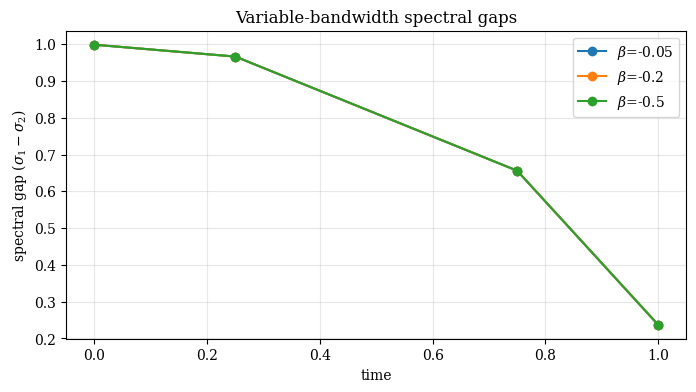

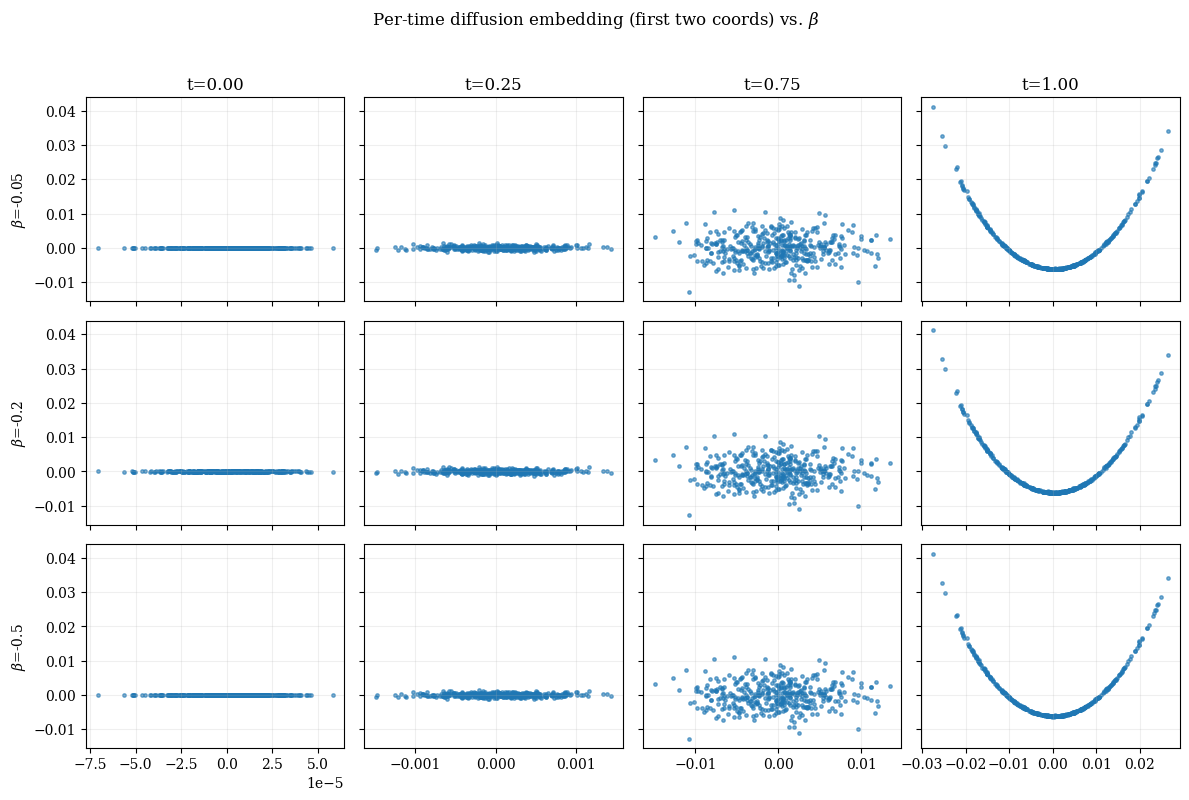

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
for beta in variable_beta_grid:
    subset = variable_bw_df[variable_bw_df['beta'] == beta]
    ax.plot(subset['time'], subset['spectral_gap'], 'o-', label=rf'$\beta$={beta}')
ax.set(xlabel='time', ylabel=r'spectral gap ($\sigma_1 - \sigma_2$)', title='Variable-bandwidth spectral gaps')
ax.grid(alpha=0.3)
ax.legend()
plt.show()

subset_size = min(400, n_samples)
rng = np.random.default_rng(0)
sample_idx = rng.choice(n_samples, size=subset_size, replace=False)

n_rows = len(variable_beta_grid)
n_cols = T_train
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2.6 * n_rows), sharex='col', sharey='row')
axes = np.array(axes, ndmin=2).reshape(n_rows, n_cols)
for r, beta in enumerate(variable_beta_grid):
    embeds = variable_embeddings[beta][:, sample_idx, :]
    for c, t in enumerate(train_times):
        ax = axes[r, c]
        coords = embeds[c, :, :2]
        ax.scatter(coords[:, 0], coords[:, 1], s=6, alpha=0.6)
        if r == 0:
            ax.set_title(f't={t:.2f}')
        if c == 0:
            ax.set_ylabel(rf'$\beta$={beta}')
        ax.grid(alpha=0.2)
plt.suptitle(r'Per-time diffusion embedding (first two coords) vs. $\beta$', y=1.02)
plt.tight_layout()
plt.show()


In [14]:
tc_result = time_coupled_diffusion_map(
    list(metric_train_frames),
    k=tc_k,
    alpha=tc_alpha,
    epsilons=selected_epsilons,
    variable_bandwidth=use_variable_bandwidth,
    beta=tc_beta,
    density_bandwidths=base_density_bandwidths.tolist(),
    t=T_train,
)

print(f"Built {len(tc_result.transition_operators)} per-time diffusion operators.")
eps_summary = ', '.join(f'{eps:.3e}' for eps in selected_epsilons)
print(f'Selected epsilons: [{eps_summary}]')
if use_variable_bandwidth:
    bw_summary = ', '.join(f'{bw:.3e}' for bw in base_density_bandwidths)
    print(f'KDE bandwidths: [{bw_summary}] (per time slice)')
print(f"Final singular values (first five): {tc_result.singular_values[:5]}")


Built 4 per-time diffusion operators.
Selected epsilons: [1.320e+03, 2.386e+01, 1.153e+00, 2.543e-01]
KDE bandwidths: [3.111e+00, 4.713e-01, 1.323e-01, 6.601e-02] (per time slice)
Final singular values (first five): [1.00000000e+00 3.16356272e-06 1.23851153e-06 1.16867099e-06
 1.08464554e-06]


In [15]:
tc_embeddings_time, tc_stationaries, tc_sigma_traj = build_time_coupled_trajectory(
    tc_result.transition_operators,
    embed_dim=tc_k,
)
tc_coords_flat = tc_embeddings_time.transpose(1, 0, 2).reshape(-1, tc_k)
print(
    f"Time-coupled coord tensor: {tc_embeddings_time.shape}; flattened samples: {tc_coords_flat.shape}"
)


Time-coupled coord tensor: (4, 5000, 8); flattened samples: (20000, 8)


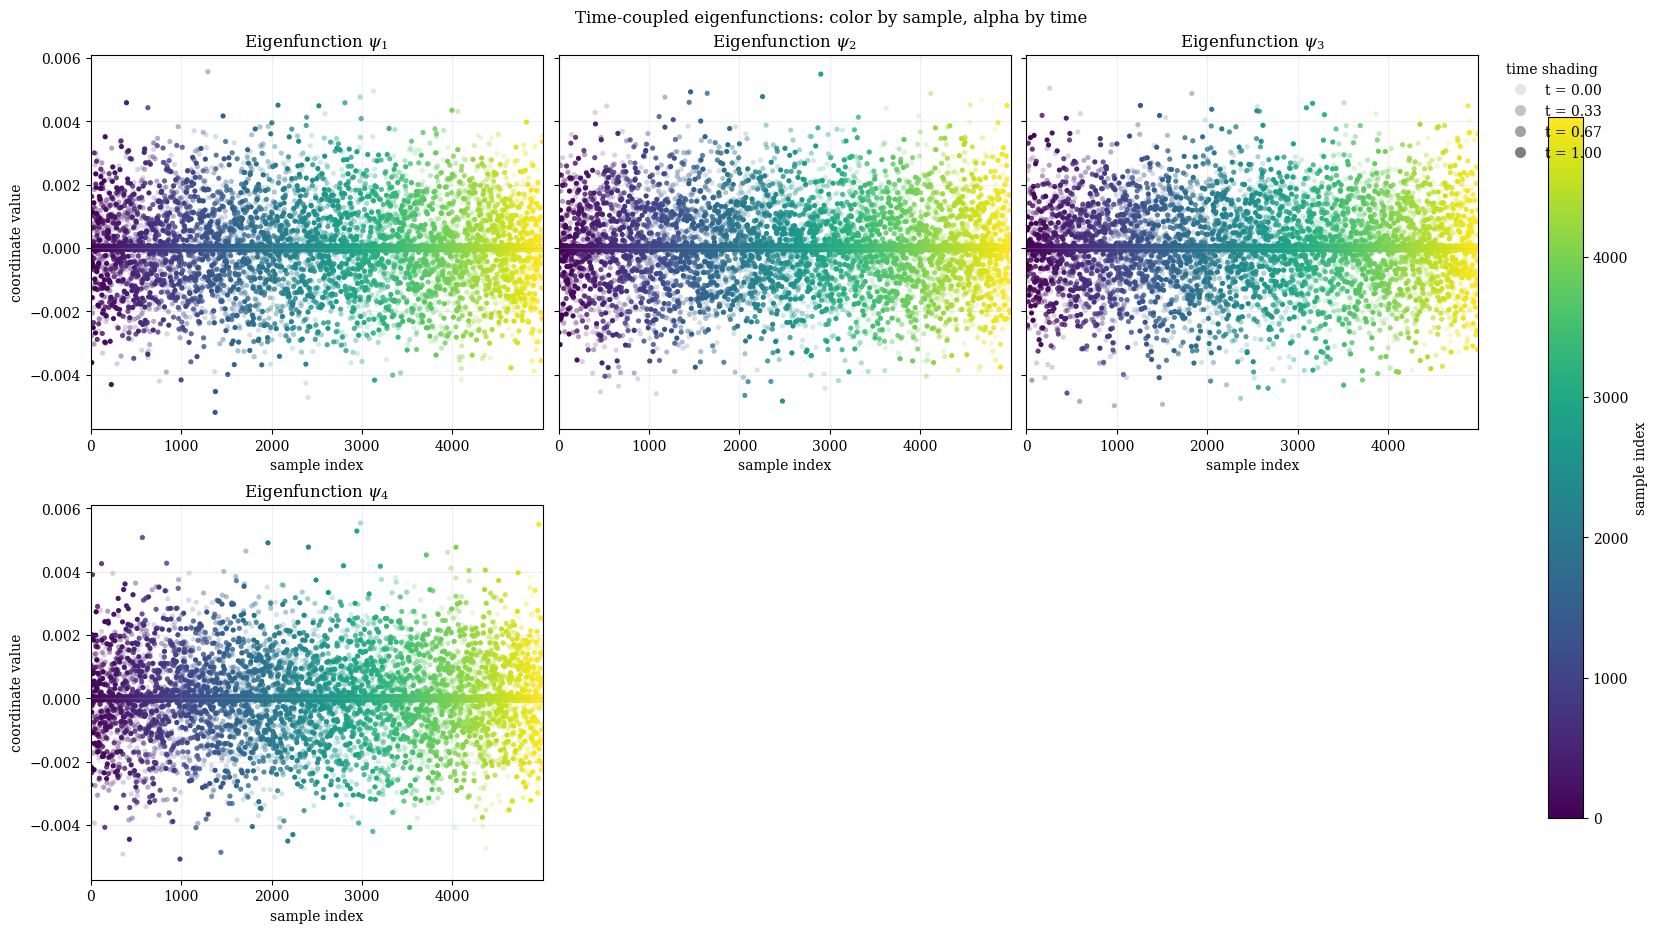

In [16]:
try:
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping eigenfunction evolution plot.')
else:
    times = np.asarray(train_times, dtype=np.float64)
    if times.ndim != 1 or times.size == 0:
        raise ValueError('train_times must be a non-empty 1D array.')
    coords = tc_coords_flat
    num_modes = coords.shape[1]
    sample_ids = np.arange(n_samples)
    num_times = times.size
    sample_flat = np.tile(sample_ids, num_times)
    time_flat = np.repeat(times, n_samples)

    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=0, vmax=max(1, n_samples - 1))
    colors = cmap(norm(sample_flat))

    time_range = times.max() - times.min()
    alpha_min, alpha_max = 0.2, 1.0
    if time_range <= 0:
        alpha_vals = np.full_like(time_flat, 0.75)
    else:
        normalized_time = (time_flat - times.min()) / time_range
        alpha_vals = alpha_min + (alpha_max - alpha_min) * normalized_time
    alpha_vals = np.clip(alpha_vals, alpha_min, alpha_max)
    colors[:, -1] = alpha_vals

    components_to_show = min(4, num_modes)
    if components_to_show == 0:
        raise ValueError('No coordinates available for plotting.')
    n_cols = min(components_to_show, 3)
    n_rows = int(np.ceil(components_to_show / n_cols))
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        sharey=True,
        figsize=(5.5 * n_cols, 4.5 * n_rows),
        constrained_layout=True,
    )
    axes = np.atleast_1d(axes).ravel()

    for comp_idx, ax in enumerate(axes):
        if comp_idx >= components_to_show:
            ax.axis('off')
            continue
        ax.scatter(
            sample_flat,
            coords[:, comp_idx],
            c=colors,
            s=14,
            edgecolors='none',
        )
        ax.set_title(f'Eigenfunction $\\psi_{comp_idx + 1}$')
        ax.set_xlabel('sample index')
        if comp_idx % n_cols == 0:
            ax.set_ylabel('coordinate value')
        ax.grid(alpha=0.2)
        ax.set_xlim(-0.5, n_samples - 0.5)

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.tolist(), shrink=0.85)
    cbar.set_label('sample index')

    if time_range > 0:
        time_ticks = np.linspace(times.min(), times.max(), num=4)
        alpha_ticks = alpha_min + (alpha_max - alpha_min) * (
            (time_ticks - times.min()) / time_range
        )
        alpha_handles = [
            plt.Line2D(
                [0],
                [0],
                marker='o',
                linestyle='',
                markerfacecolor='gray',
                markeredgecolor='none',
                markersize=8,
                alpha=alpha,
                label=fr't = {t_tick:.2f}',
            )
            for t_tick, alpha in zip(time_ticks, alpha_ticks)
        ]
        leg = fig.legend(
            handles=alpha_handles,
            loc='upper right',
            bbox_to_anchor=(0.975, 0.975),
            title='time shading',
            frameon=False,
        )
        leg._legend_box.align = 'left'

    fig.suptitle('Time-coupled eigenfunctions: color by sample, alpha by time', y=1.02)
    plt.show()

In [17]:

spline_type = 'pchip'
spline_window_mode = 'triplet'

sample_splines = []
for sample_idx in range(n_samples):
    coords_sample = tc_embeddings_time[:, sample_idx, :]
    splines = fit_coordinate_splines(
        coords_sample,
        train_times,
        spline_type=spline_type,
        window_mode=spline_window_mode,
    )
    sample_splines.append(splines)

g_star = np.vstack([
    evaluate_coordinate_splines(splines, holdout_time).ravel()
    for splines in sample_splines
])
print(f"Spline interpolation complete: {len(sample_splines)} samples; latent dim = {g_star.shape[1]}")


Spline interpolation complete: 5000 samples; latent dim = 8


In [18]:

from scipy.optimize import minimize
from scipy.spatial import cKDTree

latent_training = tc_coords_flat
micro_training = tabular_train_frames
latent_tree = cKDTree(latent_training)

def _solve_simplex_weights(phi_target, phi_neighbors):
    phi_target = np.asarray(phi_target, dtype=np.float64)
    phi_neighbors = np.asarray(phi_neighbors, dtype=np.float64)
    K = phi_neighbors.shape[0]
    if K == 1:
        return np.array([1.0], dtype=np.float64)

    def objective(b):
        diff = phi_neighbors.T @ b - phi_target
        return 0.5 * float(diff @ diff)

    def gradient(b):
        diff = phi_neighbors.T @ b - phi_target
        return phi_neighbors @ diff

    bounds = [(0.0, 1.0)] * K
    constraints = [{'type': 'eq', 'fun': lambda b: np.sum(b) - 1.0}]
    x0 = np.full(K, 1.0 / K, dtype=np.float64)
    result = minimize(
        objective,
        x0,
        jac=gradient,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 500, 'ftol': 1e-9},
    )
    if not result.success:
        weights = np.maximum(x0, 0.0)
    else:
        weights = np.clip(result.x, 0.0, 1.0)
    total = weights.sum()
    if total <= 0:
        weights = np.full(K, 1.0 / K, dtype=np.float64)
    else:
        weights /= total
    return weights


def lift_macrostate(phi_target, *, K=64):
    distances, indices = latent_tree.query(phi_target, k=K)
    indices = np.atleast_1d(indices)
    distances = np.atleast_1d(distances)
    phi_neighbors = latent_training[indices]
    micro_neighbors = micro_training[indices]
    weights = _solve_simplex_weights(phi_target, phi_neighbors)
    lifted_state = weights @ micro_neighbors
    metadata = {
        'indices': indices,
        'distances': distances,
        'weights': weights,
    }
    return lifted_state, metadata


In [19]:

lifting_K = max(int(tc_k + 2), 8)
# lifting_K = 4

lifted_predictions = np.zeros((n_samples, n_components), dtype=np.float64)
lifting_metadata = []

for sample_idx, phi_target in enumerate(g_star):
    lifted_state, meta = lift_macrostate(phi_target, K=lifting_K)
    lifted_predictions[sample_idx] = lifted_state
    meta['sample_idx'] = sample_idx
    lifting_metadata.append(meta)

rmse_per_sample = np.sqrt(np.mean((lifted_predictions - holdout_frames) ** 2, axis=1))
rmse_mean = float(rmse_per_sample.mean())
print(f'Lifting mean RMSE: {rmse_mean:.4f}')
if linear_rmse is not None:
    print(f'Linear baseline RMSE: {linear_rmse:.4f}')


Lifting mean RMSE: 0.1816
Linear baseline RMSE: 0.0699


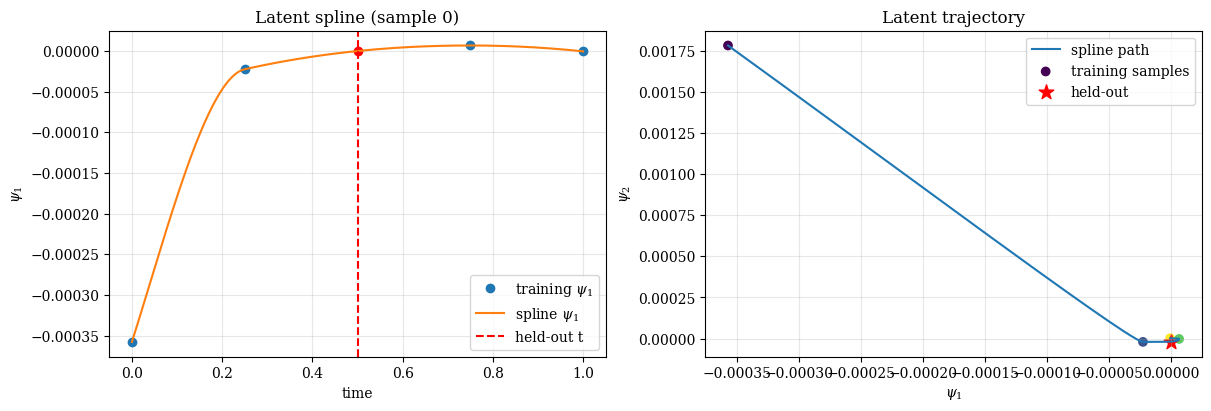

In [20]:

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping latent spline visualization.')
else:
    sample_to_plot = 0
    t_dense = np.linspace(train_times.min(), train_times.max(), 200)
    splines = sample_splines[sample_to_plot]
    phi_dense = np.vstack([
        evaluate_coordinate_splines(splines, t).ravel()
        for t in t_dense
    ])

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    axes[0].plot(train_times, tc_embeddings_time[:, sample_to_plot, 0], 'o', label='training $\\psi_1$')
    axes[0].plot(t_dense, phi_dense[:, 0], '-', label='spline $\\psi_1$')
    axes[0].axvline(holdout_time, color='red', linestyle='--', label='held-out t')
    axes[0].scatter([holdout_time], [g_star[sample_to_plot, 0]], color='red')
    axes[0].set(
        xlabel='time',
        ylabel='$\\psi_1$',
        title=f'Latent spline (sample {sample_to_plot})',
    )
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    if phi_dense.shape[1] >= 2:
        axes[1].plot(phi_dense[:, 0], phi_dense[:, 1], '-', color='tab:blue', label='spline path')
        axes[1].scatter(
            tc_embeddings_time[:, sample_to_plot, 0],
            tc_embeddings_time[:, sample_to_plot, 1],
            c=train_times,
            cmap='viridis',
            marker='o',
            label='training samples',
        )
        axes[1].scatter(
            g_star[sample_to_plot, 0],
            g_star[sample_to_plot, 1],
            color='red',
            marker='*',
            s=120,
            label='held-out',
        )
        axes[1].set(
            xlabel='$\\psi_1$',
            ylabel='$\\psi_2$',
            title='Latent trajectory',
        )
        axes[1].legend()
        axes[1].grid(alpha=0.3)
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Need ≥2 latent dims', ha='center', va='center')


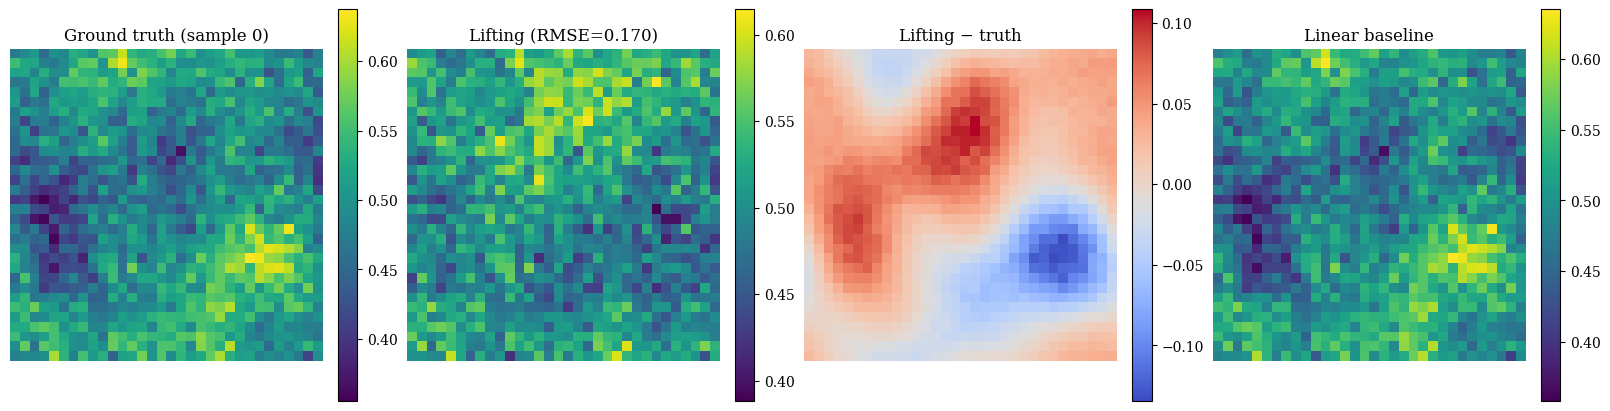

In [21]:

try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('matplotlib is not installed; skipping field reconstructions.')
else:
    def coeffs_to_image(coeffs):
        return (coeffs * sqrt_var) @ components + mean

    holdout_images = np.array([coeffs_to_image(vec) for vec in holdout_frames]).reshape(-1, side, side)
    lifted_images = np.array([coeffs_to_image(vec) for vec in lifted_predictions]).reshape(-1, side, side)
    linear_images = None
    if linear_pred is not None:
        linear_images = np.array([coeffs_to_image(vec) for vec in linear_pred]).reshape(-1, side, side)

    sample_to_plot = 0
    cols = 3 if linear_images is None else 4
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4), constrained_layout=True)

    im0 = axes[0].imshow(holdout_images[sample_to_plot], cmap='viridis')
    axes[0].set_title(f'Ground truth (sample {sample_to_plot})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(lifted_images[sample_to_plot], cmap='viridis')
    axes[1].set_title(f'Lifting (RMSE={rmse_per_sample[sample_to_plot]:.3f})')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1])

    diff = lifted_images[sample_to_plot] - holdout_images[sample_to_plot]
    im2 = axes[2].imshow(diff, cmap='coolwarm')
    axes[2].set_title('Lifting − truth')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2])

    if linear_images is not None and cols == 4:
        im3 = axes[3].imshow(linear_images[sample_to_plot], cmap='viridis')
        axes[3].set_title('Linear baseline')
        axes[3].axis('off')
        plt.colorbar(im3, ax=axes[3])


Lifting RMSE (t=0, sample=0): 1.9906


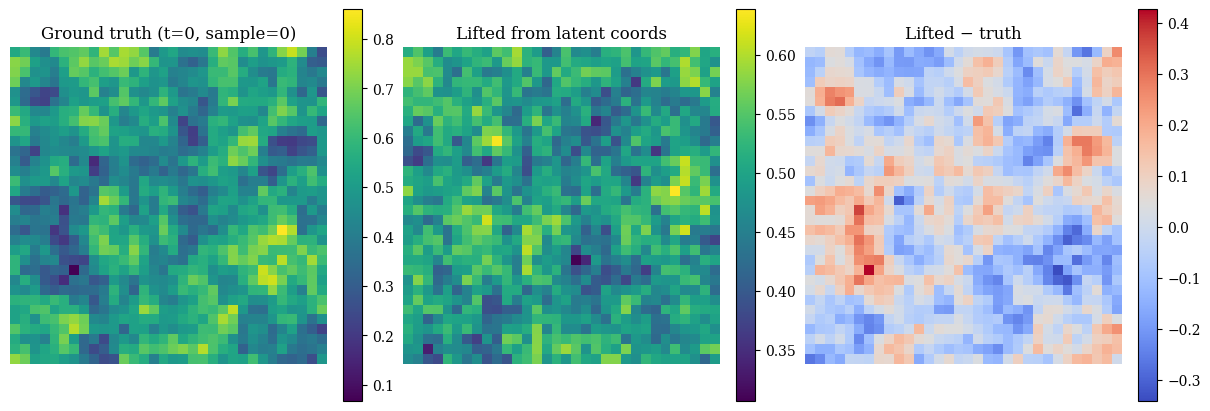

In [22]:
# test on first time step sample
phi_test = tc_embeddings_time[0, 0, :]
lifted_test, meta_test = lift_macrostate(phi_test, K=lifting_K)

# visualize and compare with ground truth
im_latent = coeffs_to_image(lifted_test).reshape(side, side)
im_truth_t0 = coeffs_to_image(all_frames[0, 0]).reshape(side, side)


fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
im0 = axes[0].imshow(im_truth_t0, cmap='viridis')
axes[0].set_title('Ground truth (t=0, sample=0)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(im_latent, cmap='viridis')
axes[1].set_title('Lifted from latent coords')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

diff = im_latent - im_truth_t0
im2 = axes[2].imshow(diff, cmap='coolwarm')
axes[2].set_title('Lifted − truth')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])
print(f"Lifting RMSE (t=0, sample=0): {np.sqrt(np.mean((lifted_test - all_frames[0, 0]) ** 2)):.4f}")